In [29]:
import tensorflow
from tensorflow import keras
import numpy as np
import os
from glob import glob
from glob import iglob
from PIL import Image

In [30]:
# Image Resizing Method
def resize_images(img_path):
	images=glob(img_path + "/*.png")  
 
	print(len(images), " images to be resized.")
 
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "PNG")
  
	print(len(images), " images resized.")

# Data Loading Method
def load_data(img_path, number_of_data=100):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=4
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in iglob(img_path+'/scissors/*.png'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=0
        idx=idx+1

    for file in iglob(img_path+'/rock/*.png'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=1
        idx=idx+1  

    for file in iglob(img_path+'/paper/*.png'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=2
        idx=idx+1
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

In [31]:
# Resize the Data Images : Train
image_dir_path = "dataset/train/scissors"
resize_images(image_dir_path)
image_dir_path =  "dataset/train/rock"
resize_images(image_dir_path)
image_dir_path = "dataset/train/paper"
resize_images(image_dir_path)

# Resize the Data Images : Test
image_dir_path = "dataset/test/scissors"
resize_images(image_dir_path)
image_dir_path =  "dataset/test/rock"
resize_images(image_dir_path)
image_dir_path = "dataset/test/paper"
resize_images(image_dir_path)


840  images to be resized.
840  images resized.
840  images to be resized.
840  images resized.
840  images to be resized.
840  images resized.
124  images to be resized.
124  images resized.
124  images to be resized.
124  images resized.
124  images to be resized.
124  images resized.


In [32]:
# Load the Dataset : Train
image_dir_path = "dataset/train"
x_train, y_train = load_data(image_dir_path, number_of_data=2520)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

# Load the Dataset : Test
image_dir_path = "dataset/test"
x_test, y_test = load_data(image_dir_path, number_of_data=372)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화
print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))


학습데이터(x_train)의 이미지 개수는 2520 입니다.
x_train shape: (2520, 28, 28, 4)
y_train shape: (2520,)
학습데이터(x_train)의 이미지 개수는 372 입니다.
x_test shape: (372, 28, 28, 4)
y_test shape: (372,)


In [33]:

# 하이퍼 파라미터
kernel_regularizer = keras.regularizers.L1(0.001)
# kernel_regularizer = None

# 모델 설계
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(28,28,4)))

model.add(keras.layers.Conv2D(16, (3,3), kernel_regularizer=kernel_regularizer))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(2,2))

model.add(keras.layers.Conv2D(32, (3,3), kernel_regularizer=kernel_regularizer))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(2,2))

model.add(keras.layers.Conv2D(64, (3,3), kernel_regularizer=kernel_regularizer))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(2,2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(3, activation='softmax'))

# 모델 개요
model.summary()

# 모델 컴파일
optimizer = 'adam'
loss = 'sparse_categorical_crossentropy',
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 8)         296       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 16)        1168      
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 24, 16)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
activation_6 (Activation)    (None, 24, 24, 16)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 10, 10, 32)       

In [34]:
# 하이퍼 파라미터
epochs = 1000

# 콜백 지정
callbacks = [
    #keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
]

# 모델 학습
result = model.fit(x_train_norm, y_train, validation_split=0.3, epochs=epochs, callbacks=callbacks)

# 모델 평가
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

Epoch 1/1000
56/56 [==============================] - 1s 8ms/step - loss: 1.3555 - accuracy: 0.9042 - val_loss: 2.2839 - val_accuracy: 0.0000e+00
Epoch 2/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.9705 - accuracy: 0.9915 - val_loss: 1.9015 - val_accuracy: 0.1071
Epoch 3/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.7945 - accuracy: 0.9972 - val_loss: 1.6278 - val_accuracy: 0.8307
Epoch 4/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.6434 - accuracy: 0.9994 - val_loss: 1.4454 - val_accuracy: 0.9630
Epoch 5/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.5149 - accuracy: 0.9994 - val_loss: 1.2352 - val_accuracy: 0.9484
Epoch 6/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.4091 - accuracy: 0.9994 - val_loss: 1.1269 - val_accuracy: 0.9550
Epoch 7/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.3250 - accuracy: 0.9994 - val_loss: 0.7384 - val_accuracy: 1.0000
Ep

56/56 [==============================] - 0s 6ms/step - loss: 0.0404 - accuracy: 1.0000 - val_loss: 0.4394 - val_accuracy: 0.8386
Epoch 59/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0278 - accuracy: 1.0000 - val_loss: 0.5786 - val_accuracy: 0.7553
Epoch 60/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0204 - accuracy: 1.0000 - val_loss: 0.4779 - val_accuracy: 0.8439
Epoch 61/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0180 - accuracy: 1.0000 - val_loss: 0.4273 - val_accuracy: 0.9272
Epoch 62/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0256 - accuracy: 0.9994 - val_loss: 0.0741 - val_accuracy: 1.0000
Epoch 63/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0725 - accuracy: 0.9960 - val_loss: 4.1559 - val_accuracy: 0.2937
Epoch 64/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.1036 - accuracy: 0.9926 - val_loss: 3.4487 - val_accuracy: 0.4550
Epoch 65/1000

56/56 [==============================] - 0s 6ms/step - loss: 0.0375 - accuracy: 0.9994 - val_loss: 0.2171 - val_accuracy: 0.9471
Epoch 116/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0362 - accuracy: 0.9989 - val_loss: 0.0803 - val_accuracy: 1.0000
Epoch 117/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0496 - accuracy: 0.9972 - val_loss: 0.0759 - val_accuracy: 0.9881
Epoch 118/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0569 - accuracy: 0.9983 - val_loss: 0.0662 - val_accuracy: 0.9974
Epoch 119/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0441 - accuracy: 1.0000 - val_loss: 0.0397 - val_accuracy: 1.0000
Epoch 120/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0302 - accuracy: 1.0000 - val_loss: 0.0414 - val_accuracy: 1.0000
Epoch 121/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0414 - accuracy: 0.9994 - val_loss: 0.0545 - val_accuracy: 1.0000
Epoch 1

Epoch 172/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0243 - accuracy: 1.0000 - val_loss: 0.0311 - val_accuracy: 1.0000
Epoch 173/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0429 - accuracy: 0.9955 - val_loss: 0.0677 - val_accuracy: 0.9921
Epoch 174/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0637 - accuracy: 0.9949 - val_loss: 0.0944 - val_accuracy: 0.9841
Epoch 175/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0522 - accuracy: 0.9989 - val_loss: 0.0451 - val_accuracy: 1.0000
Epoch 176/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0407 - accuracy: 1.0000 - val_loss: 0.0477 - val_accuracy: 0.9974
Epoch 177/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0334 - accuracy: 1.0000 - val_loss: 0.0533 - val_accuracy: 0.9960
Epoch 178/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0288 - accuracy: 1.0000 - val_loss: 0.0302 - val_accuracy:

Epoch 229/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0320 - accuracy: 1.0000 - val_loss: 0.0331 - val_accuracy: 1.0000
Epoch 230/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0283 - accuracy: 1.0000 - val_loss: 0.0818 - val_accuracy: 0.9921
Epoch 231/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0255 - accuracy: 1.0000 - val_loss: 0.0477 - val_accuracy: 1.0000
Epoch 232/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0362 - accuracy: 0.9989 - val_loss: 0.2826 - val_accuracy: 0.9444
Epoch 233/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0296 - accuracy: 1.0000 - val_loss: 0.1144 - val_accuracy: 0.9815
Epoch 234/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0251 - accuracy: 1.0000 - val_loss: 0.0911 - val_accuracy: 0.9828
Epoch 235/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0253 - accuracy: 0.9989 - val_loss: 0.0552 - val_accuracy:

Epoch 286/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0136 - accuracy: 1.0000 - val_loss: 0.0204 - val_accuracy: 1.0000
Epoch 287/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0191 - accuracy: 1.0000 - val_loss: 0.8509 - val_accuracy: 0.6376
Epoch 288/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0373 - accuracy: 0.9949 - val_loss: 0.1557 - val_accuracy: 0.9537
Epoch 289/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0816 - accuracy: 0.9921 - val_loss: 1.1628 - val_accuracy: 0.7315
Epoch 290/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0632 - accuracy: 0.9966 - val_loss: 5.5081 - val_accuracy: 0.3624
Epoch 291/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.1220 - accuracy: 0.9802 - val_loss: 0.1194 - val_accuracy: 0.9868
Epoch 292/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0758 - accuracy: 0.9989 - val_loss: 0.0712 - val_accuracy:

Epoch 343/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0359 - accuracy: 1.0000 - val_loss: 0.0815 - val_accuracy: 0.9947
Epoch 344/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0295 - accuracy: 1.0000 - val_loss: 0.0303 - val_accuracy: 1.0000
Epoch 345/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0403 - accuracy: 0.9966 - val_loss: 12.7663 - val_accuracy: 0.0000e+00
Epoch 346/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0880 - accuracy: 0.9847 - val_loss: 0.0592 - val_accuracy: 1.0000
Epoch 347/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0551 - accuracy: 0.9994 - val_loss: 0.0500 - val_accuracy: 1.0000
Epoch 348/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0470 - accuracy: 1.0000 - val_loss: 0.0454 - val_accuracy: 1.0000
Epoch 349/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0435 - accuracy: 0.9994 - val_loss: 0.0523 - val_accu

Epoch 400/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0215 - accuracy: 1.0000 - val_loss: 0.0274 - val_accuracy: 1.0000
Epoch 401/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0313 - accuracy: 0.9960 - val_loss: 0.0289 - val_accuracy: 1.0000
Epoch 402/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0429 - accuracy: 0.9972 - val_loss: 0.0499 - val_accuracy: 0.9960
Epoch 403/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0313 - accuracy: 0.9994 - val_loss: 0.0652 - val_accuracy: 0.9868
Epoch 404/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0290 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 1.0000
Epoch 405/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0275 - accuracy: 0.9994 - val_loss: 0.0364 - val_accuracy: 1.0000
Epoch 406/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0237 - accuracy: 1.0000 - val_loss: 0.0403 - val_accuracy:

Epoch 457/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0198 - accuracy: 1.0000 - val_loss: 0.0202 - val_accuracy: 1.0000
Epoch 458/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0187 - accuracy: 1.0000 - val_loss: 0.2470 - val_accuracy: 0.8902
Epoch 459/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0200 - accuracy: 0.9994 - val_loss: 0.3575 - val_accuracy: 0.8611
Epoch 460/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0487 - accuracy: 0.9932 - val_loss: 36.1893 - val_accuracy: 0.0000e+00
Epoch 461/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0525 - accuracy: 0.9960 - val_loss: 0.0446 - val_accuracy: 0.9987
Epoch 462/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0371 - accuracy: 1.0000 - val_loss: 0.0382 - val_accuracy: 1.0000
Epoch 463/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0327 - accuracy: 1.0000 - val_loss: 0.0339 - val_accu

Epoch 514/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0468 - accuracy: 1.0000 - val_loss: 0.1915 - val_accuracy: 0.9259
Epoch 515/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0437 - accuracy: 1.0000 - val_loss: 0.0774 - val_accuracy: 0.9947
Epoch 516/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0437 - accuracy: 0.9977 - val_loss: 0.0929 - val_accuracy: 0.9828
Epoch 517/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0412 - accuracy: 0.9989 - val_loss: 0.1839 - val_accuracy: 0.9378
Epoch 518/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0380 - accuracy: 0.9994 - val_loss: 0.1883 - val_accuracy: 0.9524
Epoch 519/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0342 - accuracy: 1.0000 - val_loss: 0.0818 - val_accuracy: 0.9868
Epoch 520/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0316 - accuracy: 1.0000 - val_loss: 0.0416 - val_accuracy:

Epoch 571/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0312 - accuracy: 1.0000 - val_loss: 0.0358 - val_accuracy: 1.0000
Epoch 572/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0303 - accuracy: 0.9994 - val_loss: 0.0356 - val_accuracy: 1.0000
Epoch 573/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0287 - accuracy: 1.0000 - val_loss: 0.0361 - val_accuracy: 0.9987
Epoch 574/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0283 - accuracy: 0.9994 - val_loss: 0.0817 - val_accuracy: 0.9868
Epoch 575/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0522 - accuracy: 0.9966 - val_loss: 0.1326 - val_accuracy: 0.9577
Epoch 576/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0380 - accuracy: 0.9994 - val_loss: 0.0525 - val_accuracy: 0.9974
Epoch 577/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0358 - accuracy: 0.9994 - val_loss: 2.0685 - val_accuracy:

Epoch 628/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0265 - accuracy: 0.9994 - val_loss: 0.0653 - val_accuracy: 0.9841
Epoch 629/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0258 - accuracy: 0.9989 - val_loss: 0.0250 - val_accuracy: 1.0000
Epoch 630/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0476 - accuracy: 0.9966 - val_loss: 0.0333 - val_accuracy: 0.9987
Epoch 631/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0304 - accuracy: 0.9994 - val_loss: 0.0268 - val_accuracy: 1.0000
Epoch 632/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0261 - accuracy: 1.0000 - val_loss: 0.0239 - val_accuracy: 1.0000
Epoch 633/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0226 - accuracy: 1.0000 - val_loss: 0.0213 - val_accuracy: 1.0000
Epoch 634/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0214 - accuracy: 0.9994 - val_loss: 0.0208 - val_accuracy:

Epoch 685/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0193 - accuracy: 0.9994 - val_loss: 0.0248 - val_accuracy: 1.0000
Epoch 686/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0205 - accuracy: 1.0000 - val_loss: 0.0379 - val_accuracy: 1.0000
Epoch 687/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0216 - accuracy: 1.0000 - val_loss: 0.0326 - val_accuracy: 0.9987
Epoch 688/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0206 - accuracy: 1.0000 - val_loss: 0.0585 - val_accuracy: 0.9987
Epoch 689/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0223 - accuracy: 0.9994 - val_loss: 0.0390 - val_accuracy: 1.0000
Epoch 690/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0379 - accuracy: 0.9960 - val_loss: 0.1672 - val_accuracy: 0.9511
Epoch 691/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0290 - accuracy: 0.9994 - val_loss: 0.0363 - val_accuracy:

Epoch 742/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0186 - accuracy: 1.0000 - val_loss: 0.0390 - val_accuracy: 0.9947
Epoch 743/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0169 - accuracy: 1.0000 - val_loss: 0.0269 - val_accuracy: 1.0000
Epoch 744/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0161 - accuracy: 1.0000 - val_loss: 0.0247 - val_accuracy: 1.0000
Epoch 745/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0168 - accuracy: 1.0000 - val_loss: 0.0304 - val_accuracy: 1.0000
Epoch 746/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0148 - accuracy: 1.0000 - val_loss: 0.0255 - val_accuracy: 1.0000
Epoch 747/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0202 - accuracy: 0.9994 - val_loss: 0.0218 - val_accuracy: 1.0000
Epoch 748/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0254 - accuracy: 1.0000 - val_loss: 0.0228 - val_accuracy:

Epoch 799/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0265 - accuracy: 1.0000 - val_loss: 0.0698 - val_accuracy: 0.9921
Epoch 800/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0262 - accuracy: 1.0000 - val_loss: 0.0694 - val_accuracy: 0.9934
Epoch 801/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0242 - accuracy: 1.0000 - val_loss: 0.0815 - val_accuracy: 0.9921
Epoch 802/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0233 - accuracy: 1.0000 - val_loss: 0.1091 - val_accuracy: 0.9894
Epoch 803/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0226 - accuracy: 1.0000 - val_loss: 0.1191 - val_accuracy: 0.9854
Epoch 804/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0221 - accuracy: 1.0000 - val_loss: 0.1373 - val_accuracy: 0.9775
Epoch 805/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0208 - accuracy: 1.0000 - val_loss: 0.1155 - val_accuracy:

Epoch 856/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0443 - accuracy: 1.0000 - val_loss: 0.0425 - val_accuracy: 1.0000
Epoch 857/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0413 - accuracy: 1.0000 - val_loss: 0.0442 - val_accuracy: 1.0000
Epoch 858/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0394 - accuracy: 1.0000 - val_loss: 0.0499 - val_accuracy: 1.0000
Epoch 859/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0406 - accuracy: 0.9994 - val_loss: 0.1014 - val_accuracy: 0.9828
Epoch 860/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0365 - accuracy: 1.0000 - val_loss: 0.0413 - val_accuracy: 1.0000
Epoch 861/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0346 - accuracy: 1.0000 - val_loss: 0.0360 - val_accuracy: 1.0000
Epoch 862/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0333 - accuracy: 0.9994 - val_loss: 0.0328 - val_accuracy:

Epoch 913/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0241 - accuracy: 0.9994 - val_loss: 0.0930 - val_accuracy: 0.9788
Epoch 914/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0217 - accuracy: 1.0000 - val_loss: 0.0621 - val_accuracy: 0.9881
Epoch 915/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0201 - accuracy: 1.0000 - val_loss: 0.0570 - val_accuracy: 0.9881
Epoch 916/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0189 - accuracy: 1.0000 - val_loss: 0.1592 - val_accuracy: 0.9616
Epoch 917/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0179 - accuracy: 1.0000 - val_loss: 0.0720 - val_accuracy: 0.9854
Epoch 918/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0177 - accuracy: 0.9994 - val_loss: 0.0376 - val_accuracy: 0.9947
Epoch 919/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0163 - accuracy: 1.0000 - val_loss: 0.0378 - val_accuracy:

Epoch 970/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0167 - accuracy: 1.0000 - val_loss: 0.0238 - val_accuracy: 1.0000
Epoch 971/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0155 - accuracy: 1.0000 - val_loss: 0.0261 - val_accuracy: 1.0000
Epoch 972/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0144 - accuracy: 1.0000 - val_loss: 0.0280 - val_accuracy: 1.0000
Epoch 973/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0137 - accuracy: 1.0000 - val_loss: 0.0333 - val_accuracy: 0.9987
Epoch 974/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0131 - accuracy: 1.0000 - val_loss: 0.0339 - val_accuracy: 0.9987
Epoch 975/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 0.0383 - val_accuracy: 0.9987
Epoch 976/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0119 - accuracy: 1.0000 - val_loss: 0.0794 - val_accuracy:

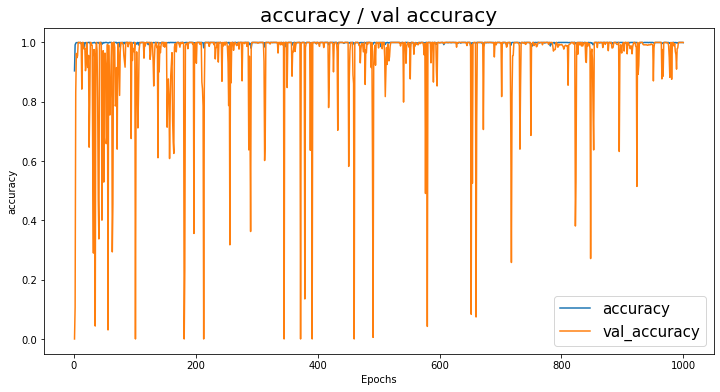

In [36]:
# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, len(result.history['accuracy'])+1), result.history['accuracy'])
plt.plot(np.arange(1, len(result.history['val_accuracy'])+1), result.history['val_accuracy'])
plt.title('accuracy / val accuracy', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'], fontsize=15)
plt.show()
